# Development: Nbody Kit

It only works on perlmutter. 

```
module swap PrgEnv-${PE_ENV,,} PrgEnv-gnu
MPICC="cc -shared" pip install --force-reinstall --no-cache-dir --no-binary=mpi4py mpi4py
```

In [1]:
import numpy as np
from astropy.table import Table
from astropy.io.fits import getdata

from fileLoc import FileLocs
floc = FileLocs(machine='nersc')


In [2]:
# from nbodykit.lab import *
# from nbodykit import setup_logging, style


## Make Patches Files

In [3]:
from fileLoc import FileLocs
from set_bins_files import SetupFiles
floc = FileLocs(machine='nersc')
path = floc.halo_run_loc

In [138]:
fname_base = path+'nbody_output/tmp/%s_mock_z%i_k%i.fits'

def make_data(z_bin):
    print('Redshift bin: %i'%z_bin)
    data = Table(getdata((path+'data_%i.fits'%z_bin)))
    rnd = Table(getdata((path+'rnd_%i.fits'%z_bin)))
    
    # slice randoms
    Nran = int(50*len(data))
    rnd = rnd[np.random.randint(len(rnd), size=Nran)]

    print('Setup Patches')
    labels = np.array(data['labels'])
    groups = np.unique(labels)
    n_patches = groups.size

    datas   = [data[data['labels']!=k] for k in groups]
    randoms = [rnd[rnd['labels']!=k] for k in groups]

    # setup file system
    tag = "mock_z%i"%z_bin
    fl = SetupFiles(tag, n_patches, root=path)
    # create tmp files
    files1, files2 = fl.write_tmp_files(datas, randoms, "mock_z%i"%z_bin, n_patches)
    # set output files
    outfiles = [fl.tmp_fname_base.format(k) for k in range(n_patches)]
    print("outfiles:",outfiles[0])
    print("infile:",files1[0])
    print("random:",files2[0])
    print()

In [142]:
for i in range(3):
    make_data(i)

Redshift bin: 0
Setup Patches
outfiles: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_mock_z0_k000
infile: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/data_mock_z0_k0.fits
random: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/rnd_mock_z0_k0.fits

Redshift bin: 1
Setup Patches
outfiles: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_mock_z1_k000
infile: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/data_mock_z1_k0.fits
random: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/rnd_mock_z1_k0.fits

Redshift bin: 2
Setup Patches
outfiles: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_mock_z2_k000
infile: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/data_mock_z2_k0.fits
random: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/rnd_mock_z2_k0.fits



In [140]:
f1 = fname_base%('data', 0, 0)
f2 = fname_base%('rnd', 0, 0)

d1 = Table(getdata(f1))
r1 = Table(getdata(f2))

In [143]:
# !ls -lth /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/*

In [9]:
out_base = fname_base%('xi', 0, 0)

In [10]:
out_base

'/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k0.fits'

## Join Output

In [144]:
def get_jk_cov(jk_stats,npatches):
    """
    Get JackKnife covariance and error bar. 
 
    Args:
        jk_stats (array): array with the statistics computed for each JK patch
        npatches (float): number of JK patches 
    """
    mean  = np.mean(jk_stats, axis =0)
    cov_jk  = np.sum((jk_stats - mean[None, :])[:, :, None] *
                 (jk_stats - mean[None, :])[:, None, :], axis=0)
    cov_jk *= ((npatches - 1.)/npatches)  
    sig_jk  = np.sqrt(np.diag(cov_jk))
    return cov_jk, sig_jk, mean

def joinFiles(files):
    r = np.load(files[0])['r']
    vec = [np.load(file)['mean'] for file in files]
    return r, np.array(vec)

In [145]:
from fileLoc import FileLocs
import glob

floc = FileLocs(machine='nersc')
path = floc.halo_run_loc
z_bin=0
fname_base = path+'nbody_output/tmp/%s_mock_z%i'
outfiles = glob.glob(fname_base%('xi', z_bin)+"_k*")
outfiles


['/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k5.npz',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k2.npz',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k9.npz',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k8.npz',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k3.npz',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k1.npz',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k4.npz',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k7.npz',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k6.npz',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/xi_mock_z0_k0.npz']

In [151]:
n_patches = len(outfiles)
r, vec = joinFiles(outfiles)
cov, sig, mean = get_jk_cov(vec, n_patches)

In [156]:
!ls /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z2_all

/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z2_all


In [ ]:
fname = '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/xi_z2_all'


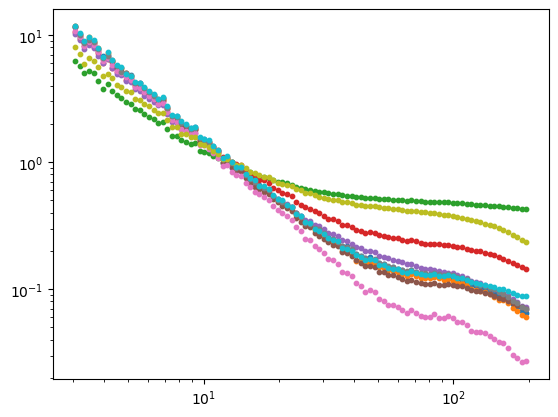

In [153]:
import matplotlib.pyplot as plt
plt.xscale('log')
for i in range(10):
    plt.loglog()
    plt.scatter(r, vec[i], s=10)
    #plt.errorbar(r, vec[i], yerr=sig)

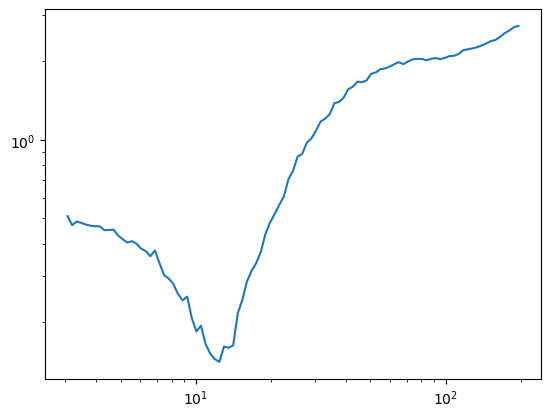

In [154]:
plt.loglog()
plt.plot(r, sig/mean)

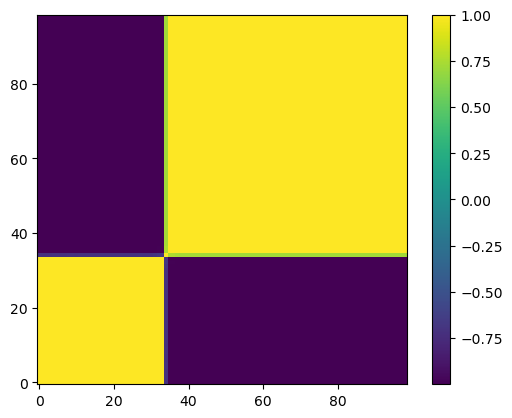

In [155]:
plt.imshow(np.corrcoef(cov),origin='lower')
plt.colorbar()

### Check Current Files

In [100]:
files = [floc.halo_run_loc+'data_%i.fits'%i for i in range(3)]
files

['/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/data_0.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/data_1.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/data_2.fits']

In [101]:
files_rnd = [floc.halo_run_loc+'rnd_%i.fits'%i for i in range(3)]
files_rnd

['/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/rnd_0.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/rnd_1.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/rnd_2.fits']

In [10]:
Table(getdata(files[0]))

FKPWeight,NZ,Position [3],Selection,Value,Weight,dec,lambda_mor,ra,z,labels
float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,int64
0.8480960924749683,1.7911167009593917e-05,340.7146816135973 .. -508.91163620711916,True,1.0,1.0,-42.0517754044981,10.062862533601052,307.15073025389347,0.27058446407318115,0
0.8476666538498514,1.7970902294940548e-05,341.44215990677503 .. -508.571399728615,True,1.0,1.0,-42.05313550692125,19.507735487705173,307.27470671757794,0.27038249373435974,0
0.8389328861266531,1.9199046376283158e-05,354.5415502114185 .. -475.2771108507036,True,1.0,1.0,-39.82394748123761,11.91423018521523,308.4656671879389,0.263835608959198,0
0.8448775053789793,1.8360353262268325e-05,346.63950707136763 .. -497.21834570585213,True,1.0,1.0,-41.11823254776729,8.228792588562362,307.4854577332952,0.2691691219806671,0
0.8447270419782714,1.8381435695262443e-05,348.3227077942536 .. -489.28736440054325,True,1.0,1.0,-40.33704591404569,11.819979785014675,307.19468371746234,0.2690989375114441,0
0.849822922959816,1.7671572863336975e-05,345.07770341878853 .. -508.305109883491,True,1.0,1.0,-41.77310834257179,6.943331940272871,307.3307214637057,0.27181583642959595,0
0.8479407371147144,1.7932770089888265e-05,344.09183188298726 .. -510.2824977769061,True,1.0,1.0,-42.204481198765336,7.03158254099195,307.7001301727229,0.27050986886024475,0
0.8399686102494356,1.9052067874660434e-05,345.85617075629887 .. -492.32735428582123,True,1.0,1.0,-41.334996588504595,5.825115772027186,308.16405213047904,0.2650974988937378,0
0.8416079904610335,1.882016465316581e-05,367.61702158699137 .. -552.5316928691108,True,1.0,1.0,-42.0608546881254,20.104353324388647,306.8948557714656,0.2956170439720154,0


In [32]:
tmp = Table(getdata(files[2]))
np.array(np.unique(tmp['labels']))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
import glob
p1 = "/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/"
files1 = glob.glob(p1+"debug_data*")
files1

['/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_data_7.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_data_6.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_data_3.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_data_4.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_data_0.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_data_8.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_data_2.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_data_9.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_data_1.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_data_5.fits']

In [15]:
files2 = glob.glob(p1+"debug_rnd*")
files2

['/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_rnd_1.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_rnd_9.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_rnd_8.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_rnd_6.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_rnd_3.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_rnd_5.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_rnd_4.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_rnd_0.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_rnd_7.fits',
 '/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/nbody_output/tmp/debug_rnd_2.fits']

## Run Nbody

In [4]:
z_bin = 0
tag = "debug"
path = floc.halo_run_loc

In [6]:
# print('Redshift bin: %i'%z_bin)
# data = FITSCatalog(path+'data_%i.fits'%z_bin)
# rnd = FITSCatalog(path+'rnd_%i.fits'%z_bin)

# print('Setup Patches')
# labels = np.array(data['labels'])
# groups = np.unique(labels)
# n_patches = groups.size

# datas   = [data[data['labels']!=k] for k in groups]
# randoms = [rnd[rnd['labels']!=k] for k in groups]


In [44]:
groups

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [45]:
n_patches

10

In [7]:
fl = SetupFiles(tag, n_patches)
outfiles = [fl.tmp_fname_base.format(k) for k in range(n_patches)]
outfiles

NameError: name 'SetupFiles' is not defined

In [48]:
print('Correlation Function')
for k in range(n_patches):
    print("Group %i/%i"%(k, n_patches))
    print("size:", datas[k].csize)
    print(outfiles[k])
    print()


Correlation Function
Group 0/10
size: 37012
./output/debug_jk_patches_00000.npy

Group 1/10
size: 40782
./output/debug_jk_patches_00001.npy

Group 2/10
size: 37308
./output/debug_jk_patches_00002.npy

Group 3/10
size: 36864
./output/debug_jk_patches_00003.npy

Group 4/10
size: 39573
./output/debug_jk_patches_00004.npy

Group 5/10
size: 37927
./output/debug_jk_patches_00005.npy

Group 6/10
size: 38098
./output/debug_jk_patches_00006.npy

Group 7/10
size: 36771
./output/debug_jk_patches_00007.npy

Group 8/10
size: 37281
./output/debug_jk_patches_00008.npy

Group 9/10
size: 37023
./output/debug_jk_patches_00009.npy



## dEv File System

In [21]:
from set_bins_files import SetupFiles
tag = "debug"
fl = SetupFiles(tag, n_patches)


In [25]:
outfiles = [fl.tmp_fname_base.format(k) for k in range(n_patches)]

In [27]:
outfiles

['./output/debug_jk_patches_00000.npy',
 './output/debug_jk_patches_00001.npy',
 './output/debug_jk_patches_00002.npy',
 './output/debug_jk_patches_00003.npy',
 './output/debug_jk_patches_00004.npy',
 './output/debug_jk_patches_00005.npy',
 './output/debug_jk_patches_00006.npy',
 './output/debug_jk_patches_00007.npy',
 './output/debug_jk_patches_00008.npy',
 './output/debug_jk_patches_00009.npy']

In [49]:
import os 

In [53]:
os.path.isdir('/global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/output/kmeans10/')

True

## Generate Data/Random Files

In [16]:
# read files
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.3)
print('halo file name: %s'%floc.mock_nbody_fname)
data = FITSCatalog(floc.mock_nbody_fname)

print('Random file name: %s'%floc.mock_random_fname)
randoms = FITSCatalog(floc.mock_random_fname)



NameError: name 'cosmology' is not defined

In [5]:
# add Cartesian position column
data['Position'] = transform.SkyToCartesian(data['ra'], data['dec'], data['z'], cosmo=cosmo)
randoms['Position'] = transform.SkyToCartesian(randoms['ra'], randoms['dec'], randoms['z'], cosmo=cosmo)


In [6]:
# Make FKP weighting
from scipy.interpolate import InterpolatedUnivariateSpline
# the sky fraction, used to compute volume in n(z)
FSKY = 1. # a made-up value
zhist = RedshiftHistogram(randoms, FSKY, cosmo, redshift='z')
alpha = 1.0 * data.csize / randoms.csize
nofz = InterpolatedUnivariateSpline(zhist.bin_centers, alpha*zhist.nbar)

# add the n(z) columns to the FKPCatalog
randoms['NZ'] = nofz(randoms['z'])
data['NZ'] = nofz(data['z'])

data['FKPWeight'] = 1.0 / (1 + data['NZ'] * 1e4)
randoms['FKPWeight'] = 1.0 / (1 + randoms['NZ'] * 1e4)


In [7]:
def redshift_slice(jointCat, zmin, zmax):
    datas = []
    for cat in jointCat:
        mask = (cat['z']>=zmin)&(cat['z']<zmax)
        datas.append(cat[mask].copy())
    return datas

# bins
zbins = np.array([0.2, 0.32, 0.373, 0.51, 0.65])
zmin_list = np.array([0.2, 0.373, 0.51])
zmax_list = np.array([0.32, 0.51, 0.64])
zmeans = np.array([0.25, 0.44, 0.575])

In [8]:
def dask_to_table(cat):
    out = Table()
    columns = list(cat.columns)
    for col in columns:
        out[col] = np.array(cat[col])
    return out

def get_labels(data, random, n_patches=10):
    import treecorr
    cat = treecorr.Catalog(ra=data['ra'], dec=data['dec'], ra_units='deg', dec_units='deg', npatch=n_patches)
    labels = cat.patch

    rcat = treecorr.Catalog(ra=random['ra'], dec=random['ra'], ra_units='deg', dec_units='deg', patch_centers=cat.patch_centers)
    labels_rnd = rcat.patch
    
    data['labels'] = labels
    random['labels'] = labels_rnd
    return data, random


In [17]:
# i = 0
# for zmin, zmax in zip(zmin_list, zmax_list):
#     print('redshift bin: %.2f < z < %.2f'%(zmin, zmax))
#     d, r = redshift_slice([data, randoms], zmin, zmax)
#     tb1 = dask_to_table(d)
#     tb2 = dask_to_table(r)
#     tb1, tb2 = get_labels(tb1, tb2, n_patches=n_patches)
    
#     tb1.write(floc.halo_run_loc+'data_%i.fits'%i, overwrite=True)
#     tb2.write(floc.halo_run_loc+'rnd_%i.fits'%i, overwrite=True)
#     i+=1

redshift bin: 0.20 < z < 0.32
redshift bin: 0.37 < z < 0.51
redshift bin: 0.51 < z < 0.64


In [ ]:

i = 0
fname_base = floc.halo_run_loc+'nbody_output/cat/%s_z%i_k%i.fits'
data = dask_to_table(data)
randoms = dask_to_table(randoms)
for zmin, zmax in zip(zmin_list, zmax_list):
    print('redshift bin: %.2f < z < %.2f'%(zmin, zmax))
    d, r = redshift_slice([data, randoms], zmin, zmax)
    d, r = get_labels(d, r, n_patches=n_patches)
    for k in n_patches:
        fname = fname_base%("data", i, k)
        fname2 = fname_base%("random", i, k)
        dk = d[d['labels']!=k] 
        rk = r[r['labels']!=k] 
        dk.write(fname, overwrite=True)
        rk.write(fname2, overwrite=True)

    i+=1

In [24]:
import treecorr
n_patches = 10

tmp = Table(getdata(files[2]))
tmp2= Table(getdata(files_rnd[2]))

ra = tmp['ra']
dec = tmp['dec']

cat = treecorr.Catalog(ra=tmp['ra'], dec=tmp['dec'], ra_units='deg', dec_units='deg', npatch=n_patches)
labels = cat.patch

rcat = treecorr.Catalog(ra=tmp2['ra'], dec=tmp2['ra'], ra_units='deg', dec_units='deg', patch_centers=cat.patch_centers)
labels_rnd = rcat.patch


In [25]:
labels_rnd

array([4, 4, 4, ..., 4, 9, 1])

In [26]:
labels

array([1, 1, 1, ..., 6, 6, 6])

In [29]:
def get_labels(data, random, n_patches=10):
    import treecorr
    cat = treecorr.Catalog(ra=data['ra'], dec=data['dec'], ra_units='deg', dec_units='deg', npatch=n_patches)
    labels = cat.patch

    rcat = treecorr.Catalog(ra=random['ra'], dec=random['ra'], ra_units='deg', dec_units='deg', patch_centers=cat.patch_centers)
    labels_rnd = rcat.patch
    return labels, labels_rnd

